<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod3/mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod3/mlflow.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>




A complete ML procedure
---
_homl3 ch2_

1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system

In [124]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

📝 Practice: Where to find datasets?
---
- [Explore the List of datasets for machine-learning research on Wikipedia]https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research
- We will go through a complete ML procedure with the `California Housing Prices` dataset from the StatLib repository


# Look at the big picture
- Goal: use California census data to build a model of housing prices
- The model should 
  - learn from this data 
  - be able to predict the median housing price in any district, 
    - given house conditions such as the population, median income, and median housing price for each block group in California

## Frame the Problem
- This is a typical `supervised learning task`
  - since the model can be trained with labeled examples
- This is a `multiple regression problem`
  - since the system will use multiple features to make a prediction
- It is also a `univariate regression problem`
  - since we are only trying to predict a single value for each district
- the data is small enough to fit in memory
  - so plain batch learning should do just fine

## Select a Performance Measure
Two typical performance measures for regression problems are
1. the root mean square error (RMSE) given $n$ samples

$\displaystyle \operatorname{RMSE}(\mathbf{X},h) = \sqrt{\frac{1}{n}\sum_{i=1}^n (h(\mathbf{x}^{(i)})-y^{(i)})^2}$

- $\mathbf{x}^{(i)}$ is the $i^{th}$ instance in the dataset
 - it is a vector of all the feature values
- $y^{(i)}$ is $\mathbf{x^{(i)}}$'s label, the desired output value for this instance
- $\mathbf{X}$ is the instance matrix, contains each instance as a row
- $h$ is the ML model's prediction function
- $\hat{y}^{(i)} = h(\mathbf{x}^{(i)})$ is the predicted value of $\mathbf{x}^{(i)}$
 - with prediction error of $\hat{y}^{(i)}-y^{(i)}$

2. mean absolute value (MAE), also called average absolute deviation

$\displaystyle \operatorname{MAE}(\mathbf{X},h) = \frac{1}{n}\sum_{i=1}^n \left|(h(\mathbf{x}^{(i)})-y^{(i)})^2\right|$

### The distance between two vectors
- RMSE is the Euclidean norm, the normal distance between two vectors
  - also called $\ell_2$ norm, noted $||\cdot||_2$ or just $||\cdot||$
- MAE is the $\ell_1$ norm, noted $||\cdot||_1$ or just $|\cdot|$
- the general $\ell_p$ norm is defined as $\displaystyle ||\mathbf{v}||_p=\left(\sum_{i=1}^m |v_i|^p\right)^\frac{1}{p}$
  - $\ell_0$ norm gives the number of $\mathbf{v}$'s nonzero components
  - $\ell_\infty$ norm gives $\mathbf{v}$'s maximum absolute component
- The higher the norm index $p$, the larger values are more significant
  - so RMSE is more sensitive to outliers than MAE
  - but when outliers are exponentially rare like in a bell-shaped distribution,
    - the RMSE generally performs well and is preferred

## Classification vs regression
- If the house prices are required to be partitioned into categories such as
  - expensive, medium and cheap
  - then this becomes a classification problem 
    - and predicting the price perfectly accurate is unimportant
- In this ML flow, actual prices are needed so it is a regression problem

# Get and explore the data

In [125]:
# 1. Get the data
housing = pd.read_csv("../datasets/housing.csv")

In [126]:
# 2. peek first 5 rows in the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [127]:
# 3. get a quick description of the data
# pay attention to the attributes

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [128]:
housing["total_bedrooms"].isnull().sum()

207

- pay attention to missing data such as 
  - total_bedrooms has 207=20640-20433 null values
- pay attention to data types such as
  - ocean_proximity has a data type object
    - it is probably a categorical attribute based on the first 5 rows

In [129]:
# 4. find all categories of a categorical attribute
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [130]:
# 5. show a statistic summary of the numerical attributes
# a percentile indicates the value below which 
# a given percentage of observations fall

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


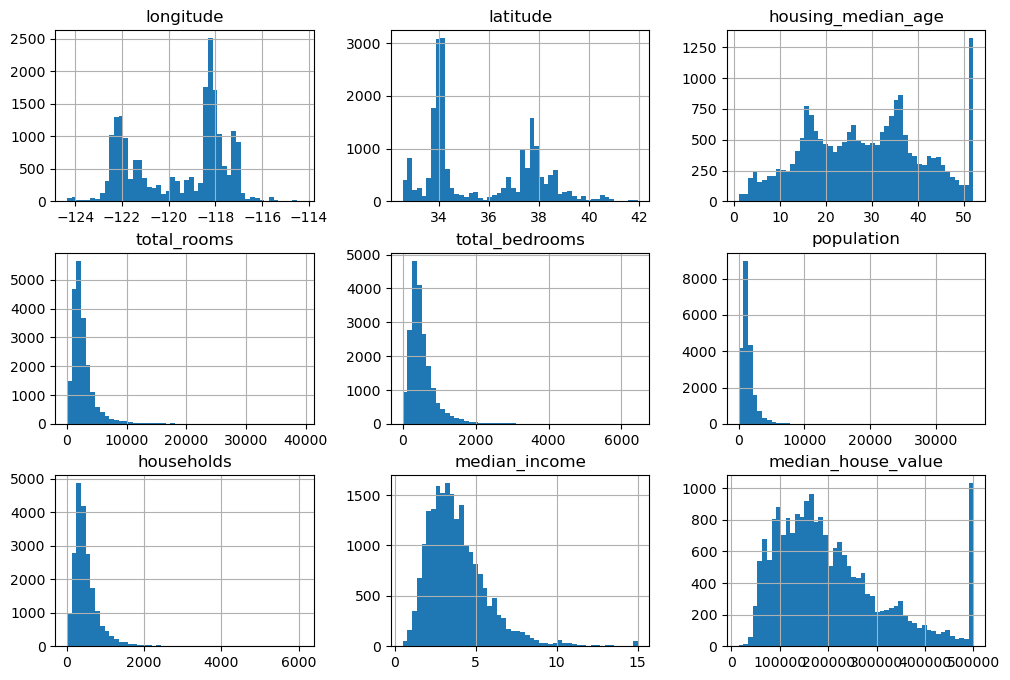

In [131]:
# 6. find the value distribution of each numerical attribute
#   with histogram
#  A histogram shows the number of instances (on the vertical axis) 
#   that fall in a given value range (on the horizontal axis)
fig1, axes1 = plt.subplots(3,3,figsize=(12,8))
housing.hist(bins=50, ax= axes1);

- Do the values above  make sense?
  - median income attribute, only 0-15? what unit?
    - scaled and capped to between [0.5, 15]
    - unit: tens of thousands of dollars
    - ∴ the median income is between [$5000, $150,000]
  - The housing median age and the median house value were also capped
    - the median house value is our target attribute, or label
  - These attributes have very different scales
    - feature scaling is needed
  - many histograms are skewed right
    - need to transform these attributes to have more symmetrical and bell-shaped distributions
- How do we know the hidden information?
  - ask the dataset collectors and publishers

## Create a Test Set
- thumb rule for splitting the dataset: 
  - 80% for training and 20% for test
- Test set generation is a critical part of a ML project
  - but it is often neglected, which incurs bad even useless ML models

In [132]:
# 1. shuffle then split data

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

- Issues: 
  - the random shuffling will generate different training set and test set every time
  - overtime, the ML model will see the whole dataset
- Tentative solutions:
  1. save the test set on the first run and then load it in subsequent runs
  2. fix the random number generator’s seed so that 
     - it always generates the same shuffled indices 
  - Problem: both these solutions will break the next time for an updated dataset
- Common solution:
  - use each instance’s identifier to decide whether or not it should go in the test set
    - assuming instances have unique and immutable identifiers
    - here, these identifiers are like container ids
  - make these identifiers comparable such as hashing them
    - then let the test set contains instances whose hashes no larger than 20% of the maximum hash value
    - This ensures that the test set will remain consistent across multiple runs
      - even the dataset is updated
- These purely random sampling methods are generally fine for dataset large enough
  - i.e. number of rows ≫ number of features
  - otherwise, a significant sampling bias could be introduced

In [133]:
# 2. use hash to ensures that 
# the test set will remain consistent across multiple runs
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
 
# The housing dataset does not have an identifier column. 
#  2.1 A simplest solution is to use the row index as the ID  
# But this requires that 
#   new data gets appended to the end of the dataset 
#   and that no row ever gets deleted
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")  

#  2.2 Another solution is 
#   combining district’s latitude and longitude into an ID like
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

- Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways
- `train_test_split()` is the simplest function among them
  - similar to the house-made `shuffle_and_split_data()` above
  - but with a couple of additional features
    - it has  a `random_state` parameter for setting the random generator seed
    - it can split multiple datasets of the same size on the same indices

In [134]:
# 3. split dataset with train_test_split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [135]:
# the split randomness looks uniform and acceptable
test_set["total_bedrooms"].isnull().sum()/housing["total_bedrooms"].isnull().sum()

0.21256038647342995

### Stratified sampling
- divides the population into homogeneous subgroups called strata
- then samples the right number of instances from each stratum
- guarantees that the test set is representative of the overall population
- In a dataset, 
  - it is important to have a sufficient number of instances for each stratum
  - otherwise, the estimate of a stratum’s importance may be biased
- `sklearn.model_selection` package provides a number of splitter classes
- Each splitter has a `split()` method that returns an iterator 
  - over different training/test splits of the same data
  - it yields the training and test indices, not the data itself
  - this is very useful for cross-validation


In [136]:
# Stratified sampling
# 1. the US population is 51.1% females and 48.9% males, 
#   so a well-conducted survey in the US would try to maintain 
#   this ratio in the sample: 511 females and 489 males

# 1.1 the probability of getting a biased sample with 
#   <48.5% female or
#   >53.5% female
# The `cdf()` method of the binomial distribution gives us 
# the probability of `the number of females ≤ the given value`

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


In [137]:
# 1.2 Obtain the same result by simulation
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

In [138]:

# 2. Stratify the median incomes in the California house dataset
#   create an income category attribute with five categories 
#   labeled from 1 to 5

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

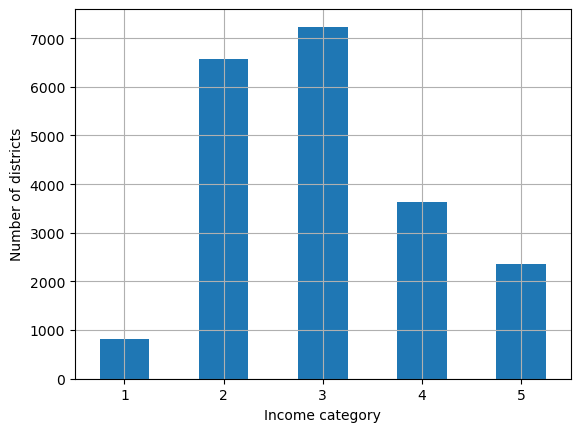

In [139]:
# 2.1 visualize the income categories

axes2 = housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
axes2.set_xlabel("Income category")
axes2.set_ylabel("Number of districts");

In [140]:
# 3. generates 10 different splits of the California house dataset
#    stratified on the income categories

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [141]:
# 3.1 use the last split
strat_train_set, strat_test_set = strat_splits[-1]

In [142]:
# 3.2 a short way to get a single stratified split
#   with `train_test_split`

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

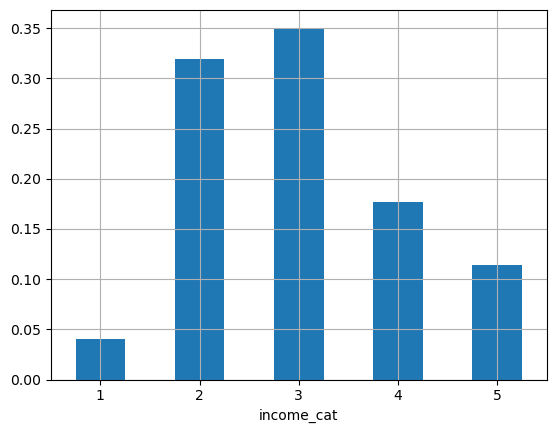

In [143]:
# 3.3 check if the stratified split worked as expected
#   check the similarity of this figure with the previous one

axes3 = (strat_test_set["income_cat"].value_counts() / len(strat_test_set)).sort_index().plot.bar(rot=0, grid=True);

In [144]:
# 3.4 compares the income category proportions in  
#   the overall dataset, 
#   the test set generated with stratified sampling, 
#   the test set generated using purely random sampling

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


The table shows
- the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, 
- whereas the test set generated using purely random sampling is skewed

In [145]:
# 3.5 the income_cat column can be dropped if it is not used again
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# Explore and Visualize the Data to Gain Insights
- put the test set aside and explore the training set only
- better work on a copy of the training set 
  - since various transformations will be experimented
- sample an exploration set if the training set is very large

In [146]:
# 1. make a copy of the original training set since it is small
housing = strat_train_set.copy()

## Visualizing Geographical Data

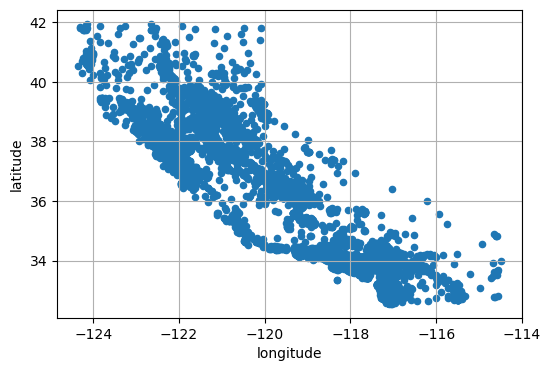

In [147]:
# 1 the data point distribution looks like California

fig4, axes4 = plt.subplots(figsize=(6,4))
housing.plot(ax=axes4, kind="scatter", x="longitude", y="latitude", grid=True);

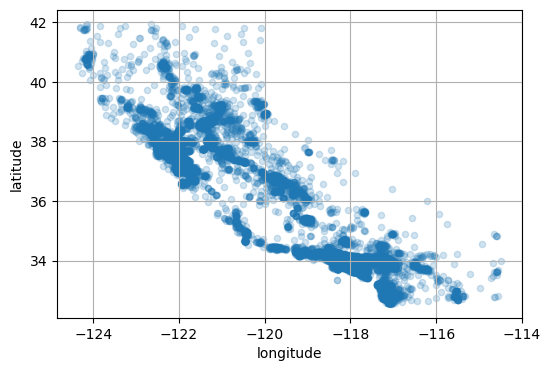

In [148]:
# 2 visualize data point density with partially transparency
# What are those areas of high density?

fig5, axes5 = plt.subplots(figsize=(6,4))
housing.plot(ax=axes5, kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2);

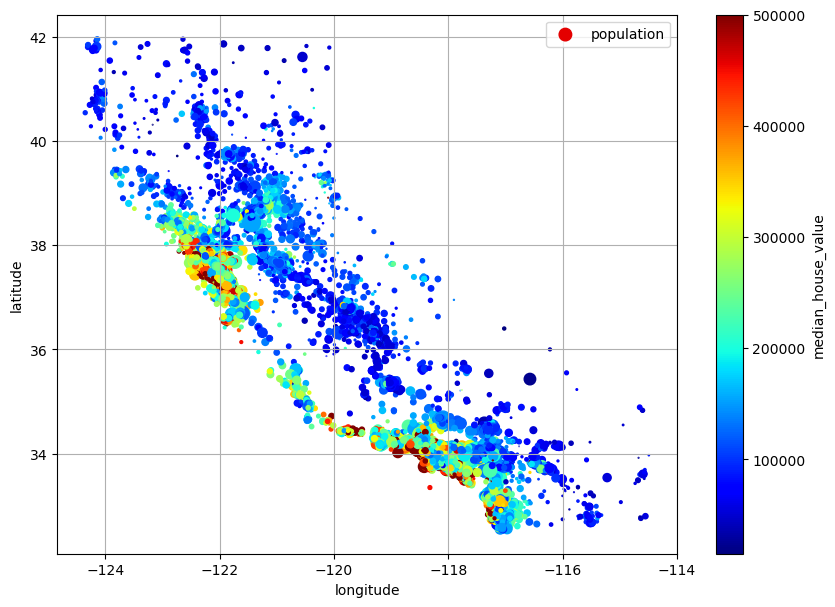

In [149]:
# 3. visualize 
#   housing prices with pseudo-colors
#   district's population with circle sizes
# It shows the housing prices are very much related to 
#   the location and 
#   the population density

fig6, axes6 = plt.subplots(figsize=(10,7))
housing.plot(ax=axes6, kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False);

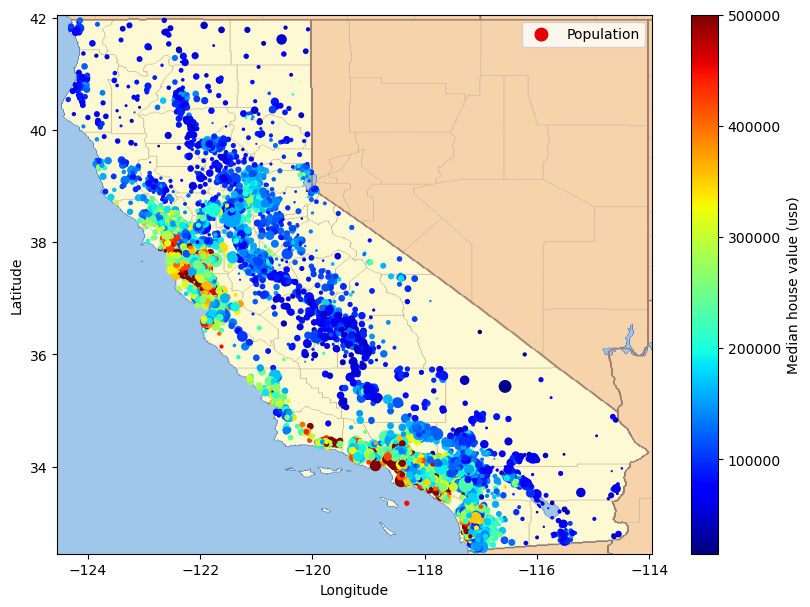

In [150]:
# 4. visualize house price and district's population on the map of California
filename = "../datasets/california.png"

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

fig7, axes7 = plt.subplots(figsize=(10,7))
housing_renamed.plot(ax=axes7,
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False)

california_img = plt.imread( filename)
axis = (-124.55, -113.95, 32.45, 42.05)
axes7.axis(axis)
axes7.imshow(california_img, extent=axis);

## Look for [Correlations](https://en.wikipedia.org/wiki/Correlation) between features
- The correlation coefficient only measures linear correlations, such as
  - x goes up, y generally goes up/down
  - this has nothing to do with the slope
- It may completely miss out on nonlinear relationships
- Purposes
  - identify and clean outliers
  - identify and transform skewed distributions

In [151]:
# 1. compute the standard correlation coefficient between every pair of attributes
#     also called Pearson’s r
corr_matrix = housing.corr(numeric_only=True)

In [152]:
# 1.2 find out how much each attribute correlates with the median house value
# Explain
#   - positive correlation, negative correlation and no correlation

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

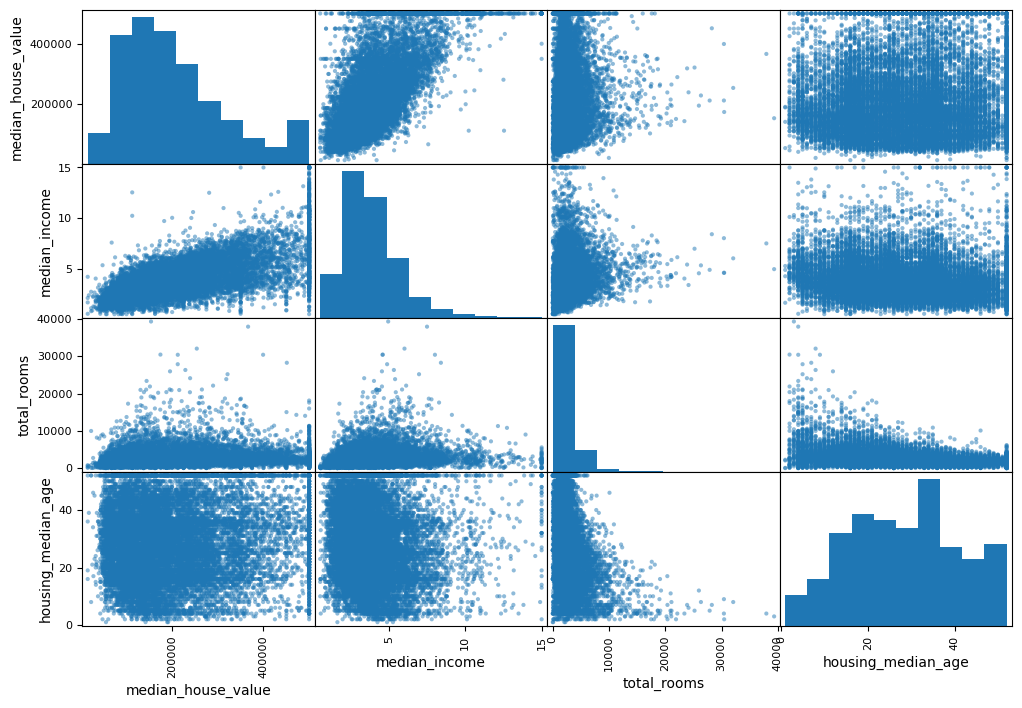

In [153]:
# 2. check for correlation between attributes 
#     using the Pandas scatter_matrix() function
# It plots every numerical attribute against every other numerical attribute. 
#    - Since there are now 11 numerical attributes, 
#       - you would get 11² = 121 plots
#    - we may choose a few attributes that seem 
#       - most correlated with the median housing value
# Note: Pandas displays a histogram of each attribute on the main diagonal

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

fig8, axes8 = plt.subplots(4,4, figsize=(12, 8))
scatter_matrix(housing[attributes], ax=axes8);

- there is a strong positive correlation between `median_income` and `median_house_value`

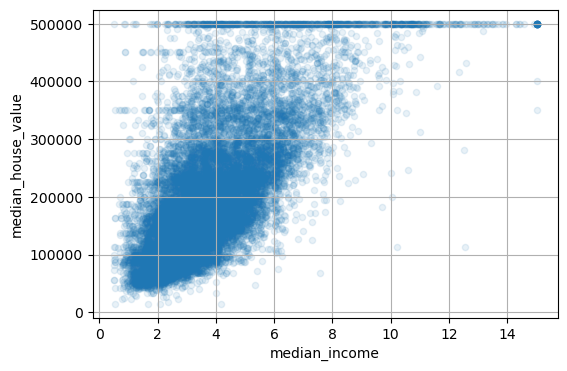

In [154]:
# 3. zoom in the correlation between `median_income` and `median_house_value`
# there are several horizontal lines in the figure
# the most obvious horizontal line is at $500,000,
#   which is the price cap
# It is better remove the corresponding districts from the data set

fig9, axes9 = plt.subplots(figsize=(6, 4))
housing.plot(ax=axes9, kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True);

## Experiment with Attribute Combinations
- attribute combinations could be more meaningful than their attributes alone
- such as,
  - the number of rooms per household
  - the population per household
  - the ratio of the number of bedrooms to the number of rooms

In [155]:
# 1. Attribute combination

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [156]:
# 2. verify the correlations between the attribute combinations and the target
# Are they more correlated to the target than their component attributes?
#  - bedrooms_ratio vs. total_rooms or total_bedrooms
#  - rooms_per_house vs. total_rooms or households
#  - people_per_house vs. population or households

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [157]:
# 0. revert to a clean training set
#   - separate the predictors and the labels

housing = strat_train_set.drop("median_house_value", axis=1) # no change in place
housing_labels = strat_train_set["median_house_value"].copy()

## Clean the data
- Three options to an attributes with some missing values
  1. drop the missing values with `dropna()`
  2. remove the whole attribute with `drop()`
  3. fill the missing values with some values such as zero, the mean, the median, etc.
     - with `fillna()`
     - this is called `imputation`
- use `SimpleImputer` for option 3 instead of `fillna()`, because `SimpleImputer` has more features
  - it will store the median value of each feature
  - it is possible to impute missing values on 
    - the training set, the validation set, 
    - the test set, and any new data fed to the model
- other more powerful imputers in sklearn.impute package, to replace missing values
  - `KNNImputer` uses the mean of the k-nearest neighbors’ values of that feature
  - `IterativeImputer` uses predicted missing values with a regression model per feature

In [158]:
# show the rows that originally contained a NaN value
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [159]:
# option 1: drop the missing values

housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [160]:
# option 2: remove the whole attribute, i.e. column
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True) 
housing_option2.loc[null_rows_idx].columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'ocean_proximity'],
      dtype='object')

In [161]:
# option 3: fill the missing values with some values such as zero, the mean, the median, etc.
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  
housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [162]:
# 2.1 Create an imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # replace NaNs with the median of the attribute
# other strategies: mean, most_frequent, constant, etc.

In [163]:
# 2.2 strategy="median" only works ono numerical attributes
# create a copy of the data with only the numerical attributes
housing_num = housing.select_dtypes(include=[np.number])

In [164]:
# 2.3 fit the imputer instance to the training data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [165]:
# 2.4 the imputer simply computed the median of each attribute and
#  stored the result in its statistics_ instance variable.
#  It is safer to apply the imputer to all the numerical attributes
#  preparing for any missing values in new data.
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [166]:
# check the above results with
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [167]:
# 2.5 use this “trained” imputer to transform the training set
#   by replacing missing values with the learned medians
X = imputer.transform(housing_num)

In [168]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [169]:
imputer.strategy

'median'

In [170]:
# 2.6 X is a NumPy array, 
# it can be wrapped in a DataFrame and 
#   recover the column names and index from housing_num.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [171]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [172]:
# 2.7 Predict outliers
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [173]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [174]:
# 2.8 Drop outliers
# uncomment and run these codes if you want to drop outliers
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handling Text and Categorical Attributes
- The values of categorical attributes are limited
- They can be encoded in integers with `OrdinalEncoder` class

In [175]:
# 1. There is only one text attribute `ocean_proximity` in housing

housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

In [176]:
# 2. `ocean_proximity` has just 5 different values
#  each of which represents a category, so it is a categorical attribute.
# Convert these categories from text to numbers 
#   since most machine learning algorithms prefer to work with numbers.
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [177]:
housing_cat_encoded[:5], housing_cat[:5]

(array([[3.],
        [0.],
        [1.],
        [1.],
        [4.]]),
       ocean_proximity
 13096        NEAR BAY
 14973       <1H OCEAN
 3785           INLAND
 14689          INLAND
 20507      NEAR OCEAN)

In [178]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- Issue of `OrdinalEncoder`: ML algorithms will assume that two nearby values are more similar than two distant values
  - fine with ordered categories such as “bad”, “average”, “good”, and “excellent”
  - but bad with unordered categories such USA state names
- `one-hot encoding` can fix this issue
  - implemented in sklearn class `OneHotEncoder`
  - it encodes the categories with a binary string
    - the length of the binary string equals the number of categories, 
    - each code has only one bit that is set to 1 for the coded category

In [179]:
# 3. encode `ocean_proximity` categories with `OneHotEncoder`
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [180]:
# By default, the `OneHotEncoder` class returns a sparse array,
# because it is  a very efficient representation for matrices that contain mostly zeros,
#  it only stores the nonzero values and their positions.
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [181]:
# we can convert it to a dense array if needed by calling the `toarray()` method:
housing_cat_1hot.toarray()[:5] # compare it with housing_cat_encoded[:5]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [182]:
# or specify that `OneHotEncoder` class returns a dense array
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot[:5]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [183]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- Issue of `OneHotEncoder`
  - results in a large number of input features if the categorical attribute has a large number of possible categories
  - i.e. the binary code is very long
  - This may slow down training and degrade performance
- Possible solutions:
  - replace the categorical input with useful numerical features related to the categories
    - e.x.  replace the `ocean_proximity` feature with the distance to the ocean
  - replace each category with a learnable, low-dimensional vector called an embedding

## Feature Scaling and Transformation
- Feature scaling is one of the most important transformations on data
  - Most ML algorithms don't perform well on numerical attributes with very different scales
  - they bias toward the features with large scales
- Two common feature scaling techniques:
  -  `min-max scaling` implemented in sklearn class `MinMaxScaler`
     - $\displaystyle v'=\frac{v-v_{min}}{v_{max}-v_{min}}$
  -  `standardization` in `StandardScaler`
     - $\displaystyle v'=\frac{v-v_{mean}}{σ_v}$
     - $σ_v$ is the standard deviation
- standardization 
  - does not restrict values to a specific range
  - is much less affected by outliers
  - will break a sparse matrix unless set its `with_mean` hyperparameter to False

In [184]:
# 1. `min-max` scaling
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [185]:
# 2. `standardization` scaling
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

- Long-tail distribution is generally transformed to be roughly symmetrical for better ML training
  - but both min-max scaling and standardization will squash most values into a small range
- Ways to shrink the heavy tail before scaling
  - replace the feature with its square root
    - or raise the feature to a power between 0 and 1
  - replace the feature under a [power law distribution](https://en.wikipedia.org/wiki/Power_law) by its logarithm
  - bucket the feature
    - chop its distribution into roughly equal-sized buckets, 
    - and replace each feature value with the index of the bucket it belongs to
    - divide by the number of buckets to force the values to the 0–1 range

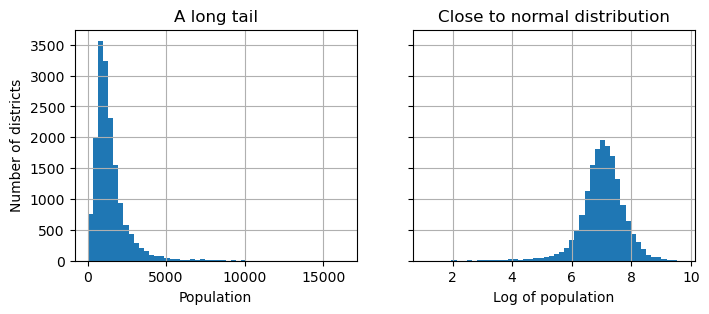

In [186]:
# 1. replace the feature under a power law distribution
# by its logarithm

figa, axesa = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axesa[0], bins=50)
housing["population"].apply(np.log).hist(ax=axesa[1], bins=50)
axesa[0].set(xlabel="Population", title='A long tail')
axesa[1].set(xlabel="Log of population", title='Close to normal distribution')
axesa[0].set_ylabel("Number of districts");

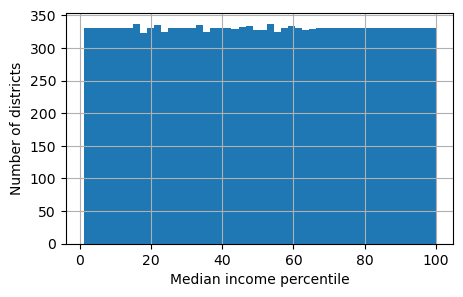

In [187]:
# 2. replace each value with its percentile
# Bucketizing with equal-sized buckets results in 
# a feature with an almost uniform distribution.

percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
figb, axesb = plt.subplots(1, 1, figsize=(5, 3))
flattened_median_income.hist(bins=50, ax=axesb)
axesb.set_xlabel("Median income percentile")
axesb.set_ylabel("Number of districts");

- A multimodal distribution has two or more clear peaks, called modes
- Bucket can also be used on a feature with a multimodal distribution
  - treat the bucket IDs as categories, rather than as numerical values
    - the bucket indices must be encoded such as using `OneHotEncoder`
  - this allows the regression model to learn different rules for different ranges of this feature value
- Another approach to transforming multimodal distributions is to
  - add a feature for each of the modes, at least the main ones
    - representing the similarity between the original feature median and that particular mode
  - Gaussian radial basis function (RBF) is typically used to measure the distance between the input value and a fixed point

In [188]:
# 1. create a new Gaussian RBF feature measuring 
# the similarity between the housing median age and 35

# The hyperparameter γ (gamma) determines how quickly 
# the similarity measure decays as x moves away from the reference 35

from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

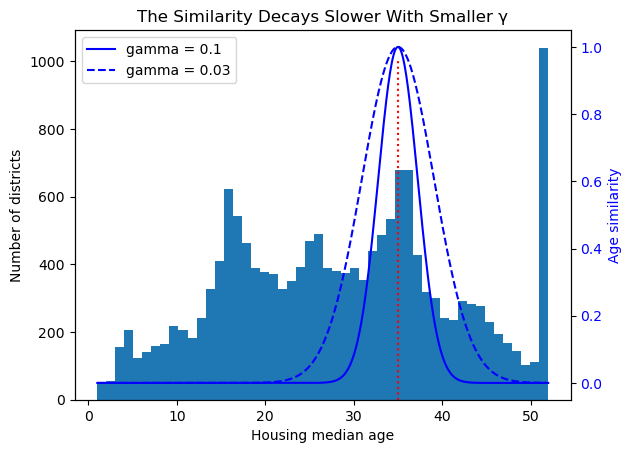

In [189]:
# 2. visualize the new similarity feature 
#     created by Gaussian RBF with two different γ's
# if this particular age group around 35 is well correlated with lower prices, 
# there’s a good chance that this new feature will help.

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

figc, axesc = plt.subplots()

axesc.set_xlabel("Housing median age")
axesc.set_ylabel("Number of districts")
axesc.hist(housing["housing_median_age"], bins=50)
axesc.vlines([35], [0], [1000], ['red'], ['dotted'])

ax2 = axesc.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label=f"gamma = {gamma1}")
ax2.plot(ages, rbf2, color=color, label=f"gamma = {gamma2}", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

ax2.legend(loc="upper left");
ax2.set_title('The Similarity Decays Slower With Smaller γ');

## Target Scaling And Transformation
- if the target distribution has a heavy tail,
  - it can be replaced with its logarithm as well
  - but the regression model will now predict the log of the target
    - so we need to compute the exponential of the model’s prediction to get the predicted target
      - this can be done with transformer method `inverse_transform()`
- A shortcut for the same purpose
  - `TransformedTargetRegressor`

In [190]:
# 1. scale and transform the target - house price
# for a final prediction, `inverse_transform` is called

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [191]:
scaled_predictions.round(2), predictions.round(2)

(array([[-0.64],
        [ 0.81],
        [-0.52],
        [-0.59],
        [-0.12]]),
 array([[131997.15],
        [299359.36],
        [146023.37],
        [138840.34],
        [192016.62]]))

In [192]:
# 1.1 Exploit the shortcut `TransformedTargetRegressor`
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [193]:
predictions.round(2)

array([131997.15, 299359.36, 146023.37, 138840.34, 192016.62])

## Custom Transformers
- are used for custom transformations, cleanup operations, or combining specific attributes
- A custom class is needed for 
  - learning some parameters in the `fit()` method, and
  - using them later in the `transform()` method

In [194]:
# 1. A simple log transformers
from sklearn.preprocessing import FunctionTransformer

# the `inverse_func` is optional unless 
# you use this transformer in a TransformedTargetRegressor
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [195]:
housing[["population"]][:2], log_pop[:2]

(       population
 13096      1576.0
 14973       666.0,
        population
 13096    7.362645
 14973    6.501290)

In [196]:
# 2. An RBF transformer used to create 
# a new feature from one old feature, 
# the distance between an old value and the landmark
landmark = [35.]
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[landmark], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [197]:
housing[["housing_median_age"]][:2], age_simil_35[:2]

(       housing_median_age
 13096                52.0
 14973                40.0,
 array([[2.81118530e-13],
        [8.20849986e-02]]))

In [198]:
# 3. An RBF transformer used to create 
# a new feature from two old features with 2D distance

landmark = (37.7749, -122.41)
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[landmark], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [199]:
housing[["latitude", "longitude"]][:2], sf_simil[:2]

(       latitude  longitude
 13096     37.80    -122.42
 14973     34.14    -118.38,
 array([[0.999927  ],
        [0.05258419]]))

In [200]:
# 4. Custom transformers are also useful to combine features
# such as computing the ratio between the input features 0 and 1

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [201]:
# 5.  a custom transformer that acts much like the `StandardScaler`
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

# TransformerMixin as a base class: 
#   the default implementation will just call fit() and then transform()
# BaseEstimator as a base class:
#   get two extra methods: get_params() and set_params()

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_


In [202]:
# 6. A custom transformer can use other estimators in its implementation
# such as using a KMeans clusterer 

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [203]:
# 6.1 use the custom transformer
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [204]:
# result: one row per district, 
# and one column per cluster, 10 columns for 10 clusters
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

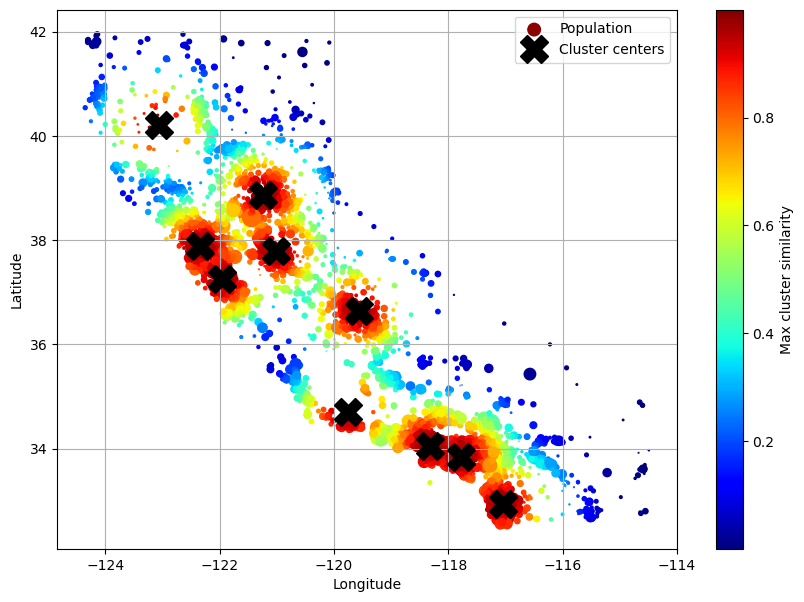

In [205]:
# 6.2 visualize the 10 cluster centers found by k-means
#   - most clusters are located in highly populated and expensive areas
#   - the districts are colored according to their geographic 
#       similarity to their closest cluster center

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

figd, axesd = plt.subplots()
housing_renamed.plot(ax=axesd, kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
axesd.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
axesd.legend(loc="upper right");

## Transformation Pipelines
- organize sequences of transformations
- can be created with 
  - the `Pipeline` class
  - the `make_pipeline()` function
- The Pipeline constructor takes a list of name/estimator pairs
  - The estimators must all be transformers
    - i.e., they must have a fit_transform() method
  - except for the last one, which can be anything: 
    - a transformer, a predictor, or any other type of estimator
- `make_pipeline()` takes transformers as positional arguments
  - creates a Pipeline using the names of the transformers’ classes
  - If multiple transformers have the same name, an index is appended
- The pipeline’s fit() method
  - calls `fit_transform()` sequentially on all the transformers
  - calls `fit()` on the final estimator
- The pipeline exposes the same methods as the final estimator

In [206]:
# 1.  a small pipeline for numerical attributes by `Pipeline` class, 
#   which will first impute then scale the input features

from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [207]:
# 1.2 by `make_pipeline` without naming the transformers explicitly
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [208]:
# 2. call num_pipeline.fit_transform
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [209]:
# 2.1 recover a DataFrame using the pipeline’s get_feature_names_out()
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [210]:
# 3. access estimators in a pipeline with 
#   - index, or
#   - the steps attribute, or
#   - the named_steps dictionary attribute

num_pipeline[1], num_pipeline.steps[1], num_pipeline.named_steps

(StandardScaler(),
 ('standardscaler', StandardScaler()),
 {'simpleimputer': SimpleImputer(strategy='median'),
  'standardscaler': StandardScaler()})

- `ColumnTransformer` applies the appropriate transformations to each column adaptively
  - `num_pipeline` on the numerical columns
  - `cat_pipeline` on the categorical columns

In [211]:
# 1. Exploit `ColumnTransformer`

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [212]:
# 1.2 Exploit `make_column_transformer()` to 
#   create a ColumnTransformer without naming each transformer explicitly

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [213]:
# 1.3 Transform all housing columns
housing_prepared = preprocessing.fit_transform(housing)

In [214]:
# 1.4 Build a DataFrame for the transformed housing
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [215]:
# 2. put all the previous transforms together
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [216]:
# 2.1 apply the synthesized ColumnTransformer on housing
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [217]:
# 2.2 show all final features
preprocessing.get_feature_names_out()


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select a model and train it


In [218]:
# 1. Start from a basic linear regression model 
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fb...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb04cc3d5d0>)])),
                ('linearregression', LinearRegression())])

In [219]:
# 1.2 try the trained model on the first five instances
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([242800., 375900., 127500.,  99400., 324600.])

In [220]:
# 1.3 Compare against the actual values:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [221]:
# 1.4 What are the relative prediction errors?
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


In [222]:
# 1.5 measure this regression model’s RMSE on the whole training set
#   using Scikit-Learn’s mean_squared_error() function
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse, lin_rmse / housing_labels.mean()

(68647.95686706669, 0.33270385400871977)

- The relative prediction error is about 33.27%
  - this signs the model underfitting the training data
  - Ways to fix underfitting
    - select a more powerful model
    - feed the training algorithm with better features
    - reduce the constraints on the model if it has
      - not the case for the basic linear regression model used above

In [223]:
# 2. Try a fairly powerful model - `DecisionTreeRegressor`
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fb...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb04cc3d5d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [224]:
# 2.1 Evaluate the tree on the training set
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

- No error!
  - A sign of overfitting or inappropriate evaluation
- Better evaluate it again with `Cross-Validation`

In [225]:
# 2.2 Evaluate the tree again with `Cross-Validation`
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [226]:
# check the scores
pd.Series(tree_rmses).describe()
# The result is  as poor as the linear regression model
# 

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [227]:
# 3. Try a more powerful model `RandomForestRegressor`
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [228]:
# 3.1 Check the validation scores again
pd.Series(forest_rmses).describe()
# much better now

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [229]:
# 3.2 Let's compare this 
#   RMSE measured using cross-validation (the "validation error") with 
#   the RMSE measured on the training set (the "training error"):

forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17547.52124624957

- The training error is much lower than the validation error
  - A sign of overfitting
  - or, there's a mismatch between the training data and the validation data
    - this is NOT the case here


# Fine-tune your model
- After got a shortlist of promising models, 
  - we need to search through their hyperparameter space to find a great combination of hyperparameter values
- `GridSearchCV` can do the search for us with a list of hyperparameters and values to try
  - It will use cross-validation to evaluate all the possible combinations of hyperparameter values

In [230]:
# 1. use `GridSearchCV` to search for the best combination of hyperparameter values 
#     for the `RandomForestRegressor` 

from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [ 
    #  3 × 3 = 9 combinations
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    # 2 × 3 = 6 combinations
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
# Total: 9 + 6 = 15 combinations
#  3-fold cross validation per combination, 15 × 3 = 45 rounds of training!
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb04cc3d5d0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [231]:
# 1.1 show the best combination of parameters
grid_search.best_params_, grid_search.best_score_

({'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6},
 -43952.588192716525)

- 'preprocessing__geo__n_clusters': 15 is a boundary value
  - so we should try a larger value and the score may continue to improve

In [232]:
# 1.2 show the best estimator
# GridSearchCV is initialized with refit=True by default, 
# then once it finds the best estimator using cross-validation, 
# it retrains it on the whole training set.
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fb04cc...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb04cc5ed90>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [233]:
# 2. Show the whole search path
# List all the test scores 
#   for each combination of hyperparameters 
#   and for each cross-validation split, 
# as well as the mean test score across all splits

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


## Randomized Search
- The grid search approach is fine with relatively few combinations
- `RandomizedSearchCV` is preferable with large hyperparameter search space
  -  it evaluates a fixed number of combinations based on 
     -  a list of possible values, or a probability distribution
  -  and selects a random value for each hyperparameter at every iteration
- The efficient versions of `RandomizedSearchCV` and `GridSearchCV`
  - `HalvingRandomSearchCV` and `HalvingGridSearchCV`  respectively

In [234]:
# 1. Exploit `RandomizedSearchCV`
# 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    # Try 30 (`n_iter` × `cv`) random combinations of hyperparameters
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb048738510>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb04c8dffd0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [235]:
# 2. displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41115,42151,42695,41987
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41812,42925,43557,42765
2,23,8,42421,43094,43856,43124


## Analyzing the Best Models and Their Errors

In [236]:
# 1. RandomForestRegressor can indicate 
# the relative importance of each attribute for making accurate predictions
# dropping the less useful features could improve computational efficiency

final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
# feature_importances.round(2)
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094476, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.01488846425739688, 'geo__Cluster 40 similarity'),
 (0.014488389218107143, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732157, 'geo__Cluster 38 similarity'),
 (0.01362570996472274, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 similari

## Evaluate The Best Model On The Test Set

In [237]:
# 1. Evaluate the best model on the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41549.20158097943


In [238]:
# 1.2 compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

In [239]:
# 1.3 Manually compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39395.35475926931, 43596.76969025394)

In [240]:
# 1.4 computes a confidence interval again using a z-score
# Since the test set is not too small, it won't make a big difference
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39396.00369767951, 43596.18328117898)

# Launch, monitor, and maintain your system
- save the best model 
- transfer the file to the production environment, and load it
- a web application is preferred
  - built with Python web frameworks such as Django, Flask, Tornado, etc.

In [241]:
# 1. save the best model with the `joblib` library 

import joblib
joblib.dump(final_model, "../models/my_california_housing_model.pkl")

['../models/my_california_housing_model.pkl']

In [242]:
# 2. deploy this model to production
final_model_reloaded = joblib.load("../models/my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [243]:
predictions

array([439808.14, 455211.06, 109492.  ,  98208.  , 340021.04])

# Scikit-Learn design principles
- `Consistency`: all objects share a consistent and simple interface
  - `Estimators`, such as `SimpleImputer`, 
    - estimates some parameters based on a dataset by the `fit()` methods
    - takes a dataset as a parameter, or dataset and labels for supervised learning algorithms
    - guides the estimation process with hyperparameters
      - such as a SimpleImputer’s `strategy`
  - `Transformers`, a special type of estimator, also called transformers
    - transforms a dataset by the `transform()` method
    - relies on the learned parameters
    - has a optimized `fit_transform()` method that calls `fit()` then `transform()`
  - `Predictors`, a special type of estimator, such as `LinearRegression`
    - also called `predictors`
    - makes predictions on new instances by the `predict()` method
    - returns corresponding predictions of given new instances
    - measures the quality of the predictions by the `score()` methods
- `Inspection` exposes estimators' internal information via public instance variables, such as
  - hyperparameters such as `imputer.strategy`
  - learned parameters such as `imputer.statistics_`
- `Nonproliferation of classes` reuses mature packages, such as
  - Datasets are represented as NumPy arrays or SciPy sparse matrices
  - Hyperparameters are just regular Python strings or numbers
- `Composition` reuses existing building blocks as much as possible, such as 
  - a Pipeline estimator is composed of an arbitrary sequence of transformers followed by a final estimator
- `Sensible defaults` provides reasonable default values for most parameters
  - quick for prototyping

# References
- [sklearn user guide](https://scikit-learn.org/stable/user_guide.html)